In [ ]:
from glob import glob

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 1
%aimport simulation_code

from simulation_code import (
    est_contrast_vifs,
    make_desmat_sub_nilearn,
)

# Goal of this Notebook  

Initial exploration of collinearity in Survey Medley models showed infinite VIFs (perfect collinearity) when including the response time regressor along with question-specific regressors, `num_possible_responses`, `num_characters`, the full cosine basis set from `fmriprep`, and derivative terms of convolved regressors.  

Since each question is modeled separately (beta series analysis), it’s impossible to include any parametric modulator with the same durations as the question-based regressors—explaining the perfect collinearities observed with the RT-based and num-based regressors.  

### Modeling RTs in fMRI  
For fMRI models, RTs can only be used as parametric modulators (with centered RTs) if RTs are less than 2s, which is the case here. This means we should be using an RT-duration regressor.  The good news is that the use of RT-duration regressors resolves the infinite collinearity issue and results in reasonable VIFs.  

Side note, I generally prefer the RT-duration style regressor, even if RTs are shorter, because I have seen some evidence of misfitting at lower RTs as well.  

### Model Comparisons in this Notebook  
We’ve already ruled out derivative regressors and can’t include `num_possible_responses` or `num_characters` due to perfect collinearity. These `num_*` values should be added as nuisance regressors in the next-level analyses.  

This leaves us with the question regressors, the cosine basis set from `fmriprep`, motion regressors, and the `rt_duration` regressor. Here, I compare the VIFs using the full high-pass filter and a reduced version.


In [2]:
events_files = glob('../data/event_files/*modified_surveyMedley_events.tsv')
sub_ids = [ef.split('/')[-1].split('_')[0] for ef in events_files]

## VIF comparison with full and reduced highpass filter

Here we compare the VIFs using all (max 5) cosine basis functions versus a reduced highpass filter that only uses the first 3 cosine basis functions (i.e., omits `cosine04` and `cosine05`, if present).

The other regressors included are:
* The question-based beta series regressors
* An RT-duration regressor
* The motion regressors (rotations and translations, including their derivatives)
  

In [3]:
vifs_rts_mot_hpfilt = []
vifs_rts_mot_reduced_hpfilt = []

for sub_id in sub_ids:
    subnum = sub_id[-3:]
    desmat_sub = make_desmat_sub_nilearn(subnum)

    if desmat_sub is not None:
        desmat_rts_mot_hpfilt_sub = desmat_sub.loc[
            :,
            ~desmat_sub.columns.str.contains('num|response_time'),
        ]
        desmat_rts_mot_reduced_hpfilt_sub = desmat_rts_mot_hpfilt_sub.loc[
            :,
            ~desmat_rts_mot_hpfilt_sub.columns.str.contains('cosine03|cosine04'),
        ]
        contrasts = {
            col_name: col_name
            for col_name in desmat_rts_mot_hpfilt_sub.columns
            if 'Q' in col_name
        }
        vifs_rts_mot_hpfilt_sub = est_contrast_vifs(
            desmat_rts_mot_hpfilt_sub, contrasts
        )
        vifs_rts_mot_hpfilt_sub['sub_id'] = sub_id
        vifs_rts_mot_reduced_hpfilt_sub = est_contrast_vifs(
            desmat_rts_mot_reduced_hpfilt_sub, contrasts
        )
        vifs_rts_mot_reduced_hpfilt_sub['sub_id'] = sub_id
        vifs_rts_mot_hpfilt.append(vifs_rts_mot_hpfilt_sub)
        vifs_rts_mot_reduced_hpfilt.append(vifs_rts_mot_reduced_hpfilt_sub)

Error for subnum 618 
 from make_first_level_design_matrix: Matrix is singular at working precision, regularizing...


In [4]:
# Double check regressors for each model
print('regressors in full model')
print(desmat_rts_mot_hpfilt_sub.columns)
print('regressors in reduced highpass filter model')
print(desmat_rts_mot_reduced_hpfilt_sub.columns)

regressors in full model
Index(['Q01', 'Q02', 'Q03', 'Q04', 'Q05', 'Q06', 'Q07', 'Q08', 'Q09', 'Q10',
       'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20',
       'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30',
       'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40',
       'rt_duration', 'constant', 'cosine00', 'cosine01', 'cosine02',
       'cosine03', 'cosine04', 'trans_x', 'trans_x_derivative1',
       'trans_x_power2', 'trans_x_derivative1_power2', 'trans_y',
       'trans_y_derivative1', 'trans_y_derivative1_power2', 'trans_y_power2',
       'trans_z', 'trans_z_derivative1', 'trans_z_power2',
       'trans_z_derivative1_power2', 'rot_x', 'rot_x_derivative1',
       'rot_x_derivative1_power2', 'rot_x_power2', 'rot_y',
       'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2',
       'rot_z', 'rot_z_derivative1', 'rot_z_power2',
       'rot_z_derivative1_power2'],
      dtype='object')
regressors in reduc

In [5]:
vifs_rts_mot_hpfilt_all = pd.concat(vifs_rts_mot_hpfilt)
vifs_rts_mot_hpfilt_all['model'] = 'RT + mot + hpfilt'
vifs_rts_mot_reduced_hpfilt_all = pd.concat(vifs_rts_mot_reduced_hpfilt)
vifs_rts_mot_reduced_hpfilt_all['model'] = 'RT + mot + reduced hpfilt'

all_vifs = pd.concat([vifs_rts_mot_hpfilt_all, vifs_rts_mot_reduced_hpfilt_all])

vifs_long = pd.melt(
    all_vifs, var_name='Q', value_name='vif', id_vars=['sub_id', 'model']
)

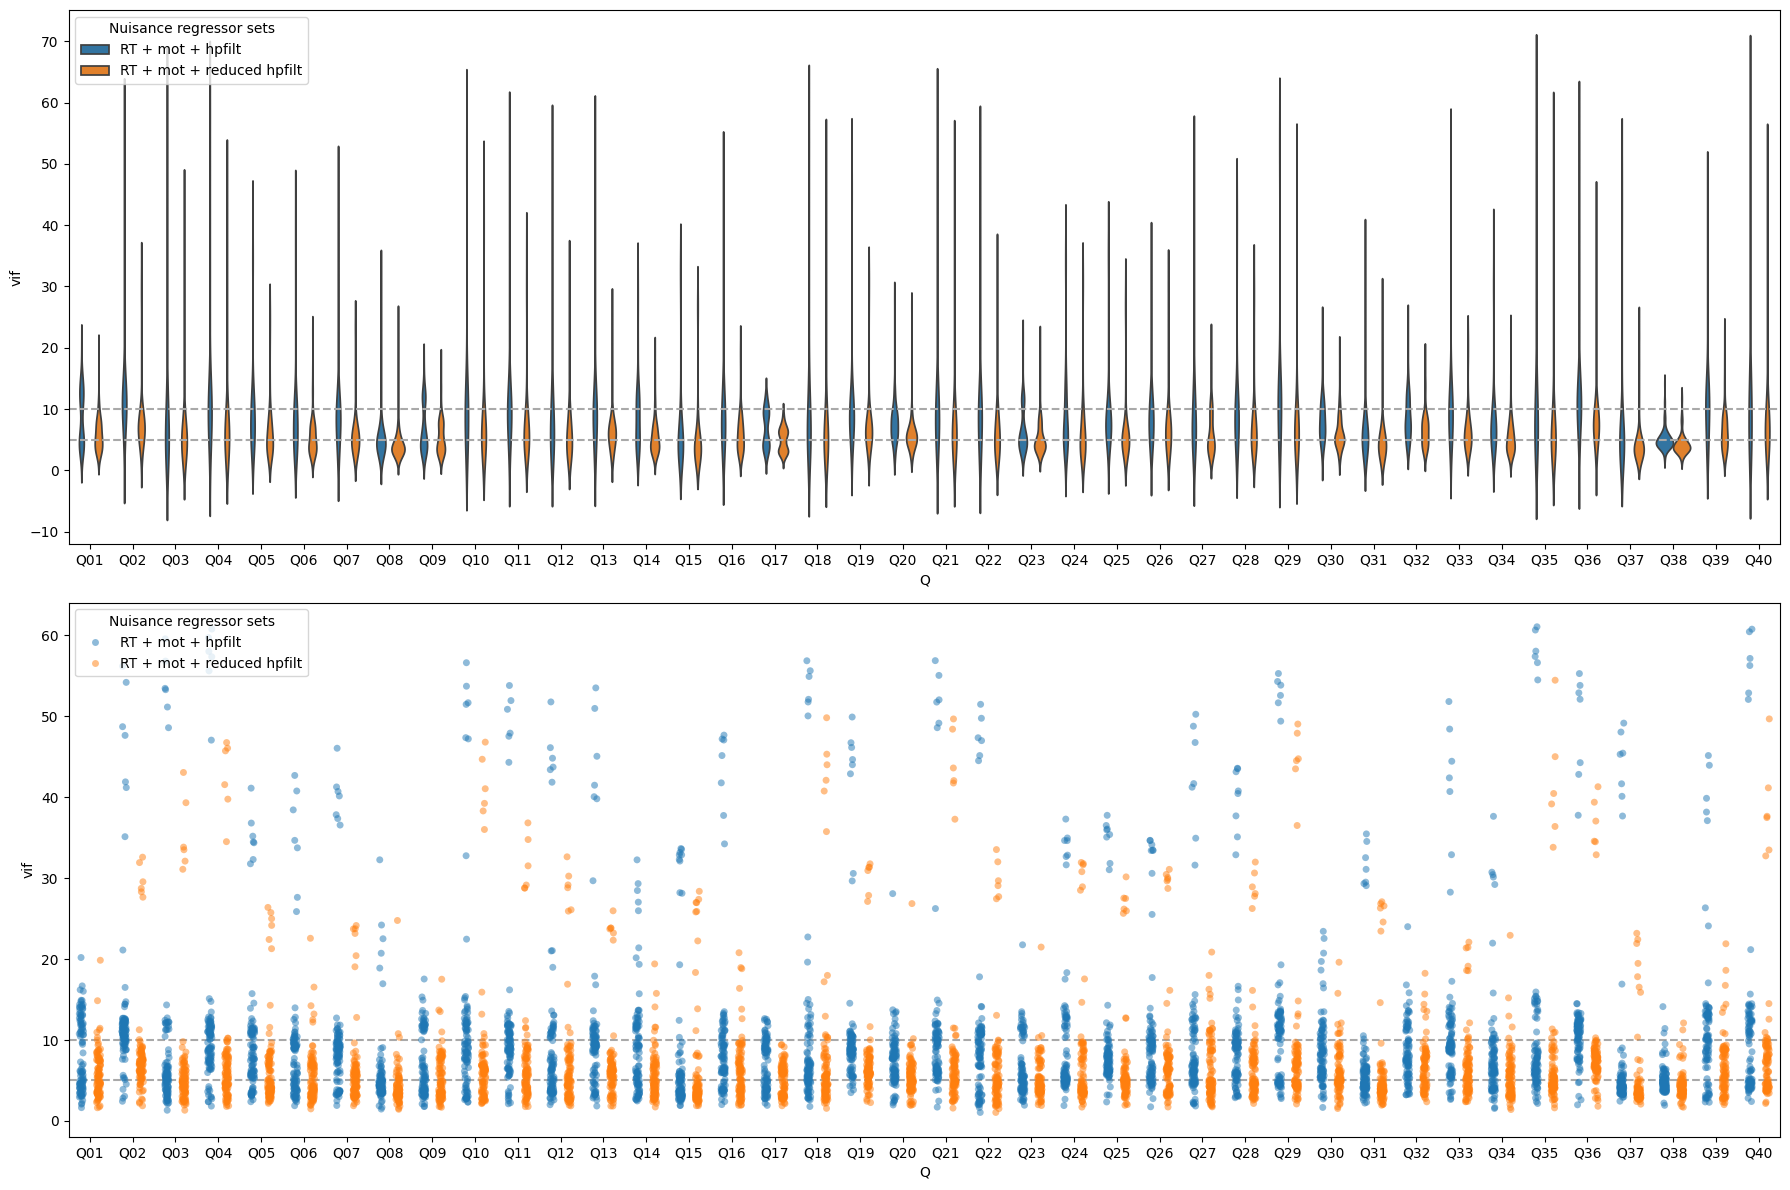

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

sns.violinplot(x='Q', y='vif', hue='model', data=vifs_long, inner=None, ax=axes[0])
axes[0].axhline(5, color='darkgray', linestyle='--')
axes[0].axhline(10, color='darkgray', linestyle='--')
axes[0].legend(title='Nuisance regressor sets', loc='upper left')

sns.stripplot(
    x='Q', y='vif', data=vifs_long, hue='model', dodge=True, alpha=0.5, ax=axes[1]
)
axes[1].legend(title='Nuisance regressor sets', loc='upper left')
axes[1].axhline(5, color='darkgray', linestyle='--')
axes[1].axhline(10, color='darkgray', linestyle='--')

plt.tight_layout()
plt.savefig('../figures/vifs_rts_mot_hpfilt.pdf')
plt.show()